In [1]:
import torch
import numpy as np
import os
from detectron2.config import get_cfg
from croptrain import add_croptrainer_config
cfg = get_cfg()
add_croptrainer_config(cfg)
cfg.merge_from_file(os.path.join(os.getcwd(), 'configs', 'RCNN-FPN-CROP.yaml'))
from croptrain.data.datasets.visdrone import load_visdrone_instances
from croptrain.data.datasets import visdrone
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.file_io import PathManager
from detectron2.data.build import get_detection_dataset_dicts, build_batch_data_loader
from detectron2.data.dataset_mapper import DatasetMapper
from detectron2.data.samplers import TrainingSampler
from detectron2.data.common import DatasetFromList, MapDataset
from croptrain.data.dataset_mapper import DatasetMapperDensityCrop
from croptrain.data.datasets.visdrone import register_visdrone
from detectron2.data.build import get_detection_dataset_dicts
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import ColorMode, Visualizer
from PIL import Image
import cv2
from detectron2.structures import Boxes
import copy

In [5]:
data_dir = os.path.join(os.environ['SLURM_TMPDIR'], "VisDrone")
dataset_name = 'visdrone_2019_train'
#register_visdrone(cfg.DATASETS.TRAIN[0], data_dir, cfg, True)
#dataset_dicts = visdrone.load_visdrone_instances(dataset_name, data_dir, cfg, True)
dataset_dicts = get_detection_dataset_dicts(cfg.DATASETS.TRAIN, filter_empty=cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS)
dataset = DatasetFromList(dataset_dicts, copy=False)
if cfg.CROPTRAIN.USE_CROPS:
    mapper = DatasetMapperDensityCrop(cfg, True)
if mapper is None:
    mapper = DatasetMapper(cfg, True)
dataset = MapDataset(dataset, mapper)
sampler = TrainingSampler(len(dataset))
data_loader = build_batch_data_loader(dataset, sampler, cfg.SOLVER.IMS_PER_BATCH)
print(len(dataset_dicts))

68901


In [17]:
def plot_image(data_image_dict, meta, scale=False):
    data_dict = copy.deepcopy(data_image_dict)
    if data_dict['full_image']:
        img = np.array(Image.open(data_dict["file_name"]))
        visualizer = Visualizer(img, metadata=meta)
        vis = visualizer.draw_dataset_dict(data_dict)
        plt.figure(figsize=(20,10))
        plt.imshow(vis.get_image()[..., ::-1][..., ::-1])
        plt.show()        
    if not data_dict['full_image']:
        img = Image.open(data_dict["file_name"])
        crop_area = data_dict['crop_area']
        x1, y1, x2, y2 = crop_area[0], crop_area[1], crop_area[2], crop_area[3]
        img = img.crop((x1, y1, x2, y2))
        min_size = min(x2-x1, y2-y1)
        
        if scale:
            scale_x, scale_y = (512/min_size), (512/min_size)
            new_size = (int((512/min_size)*(x2-x1)), int((512/min_size)*(y2-y1)))
            print(new_size, (y2-y1), min_size)
            img = img.resize(new_size)
            annos = data_dict.get("annotations", None)
            bboxes = Boxes(np.array([anno['bbox'] for anno in annos]))
            bboxes.scale(scale_x, scale_y)
            bboxes = bboxes.tensor.cpu().numpy().astype(np.int32)
            for i in range(len(bboxes)):
                data_dict["annotations"][i]["bbox"] = list(bboxes[i])
            img = np.array(img)
            visualizer = Visualizer(img, metadata=meta)
            vis = visualizer.draw_dataset_dict(data_dict)
            plt.figure()
            plt.imshow(vis.get_image()[..., ::-1][..., ::-1])
            plt.show()
        else:
            img = np.array(img)
            visualizer = Visualizer(img, metadata=meta)
            vis = visualizer.draw_dataset_dict(data_dict)            
            plt.figure(figsize=(20,10))
            plt.imshow(vis.get_image()[..., ::-1][..., ::-1])
            plt.show()
    

    
def plot_instances(data_image_dict, meta):
    data_dict = copy.deepcopy(data_image_dict)
    img = data_dict['image'].permute(1,2,0).cpu().numpy()
    data_dict["instances"].pred_boxes = data_dict["instances"].gt_boxes
    data_dict["instances"].pred_classes = data_dict["instances"].gt_classes
    visualizer = Visualizer(img, metadata=meta)
    vis = visualizer.draw_instance_predictions(data_dict["instances"])
    #if data_dict['full_image']:
    plt.figure(figsize=(20,10))
    #else:
    #    plt.figure()
    plt.imshow(vis.get_image()[..., ::-1][..., ::-1])
    plt.show()
    

False torch.Size([3, 1009, 1000])


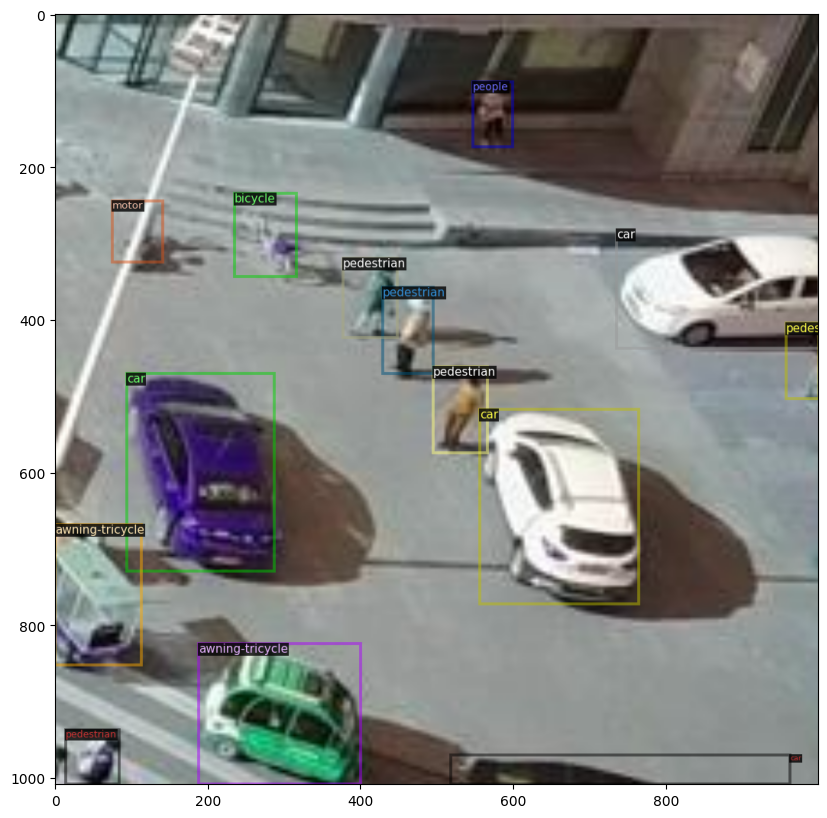

In [9]:
metadata = MetadataCatalog.get(dataset_name)
data = next(iter(data_loader))
index = 6
print(data[index]['full_image'], data[index]['image'].shape)
plot_instances(data[index], metadata)

(635, 512) 228 228


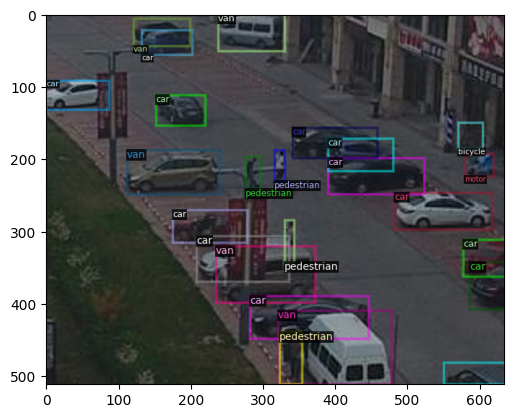

In [18]:
index = -350
#plot_image(dataset_dicts[index], metadata)
plot_image(dataset_dicts[index], metadata, True)

In [ ]:
print(len(dataset))

In [ ]:
data_dicts = visdrone.load_visdrone_instances(dataset_name, data_dir, cfg, True)
annos = dataset_dicts[0].get("annotations", None)
print(annos)